# 代码来源：邹博 的机器学习课程

# 介绍
GMM高斯混合模型（EM算法的一种应用）:

假设存在K个高斯模型(正态分布)的数据，据来自第k个模型的概率为$$\alpha_{k}$$，则GMM表示为：
$$p(y;\theta)=\sum_{k=1}^{K}\alpha_k\phi(y;\theta_k)$$

$$\sum_{k=1}^{K}\alpha_k=1,\phi(y;\theta_k)$$是第k个高斯分布密度

$$\theta_k=(\upsilon_k,\sigma_k^2)$$
$$\phi(y;\theta_k)=\frac{1}{\sqrt{2\pi}\sigma_k}exp(-\frac{(y-\upsilon_k)^2}{2\sigma_k^2})$$

# 这里以二分类高斯混合模型为例

步骤：
1. 明确隐变量，写出对数似然函数
$$\mu_k=\frac{1}{N_k}\sum_{n=1}^N\gamma(z_{nk})x_n$$
$$N_k=\sum_{n=1}^N\gamma(z_{nk})$$
$$\sum k=\frac{1}{N_k}\sum_{n=1}^{N}\gamma(z_{nk})(x_n-\mu_k)(x_n-\mu_k)^T$$
$$\pi_k=\frac{N_k}{N}$$
1. E步，确定Q函数
$$\gamma(z_{nk})=\frac{\pi_k\varkappa(x_n|\mu_n,\sum n)}{\sum_{j=1}^{K}\pi_j\varkappa(x_n|\mu_j,\sum j)}$$
1. M步，最大化Q函数
$$\mu_{k}^{new}=\frac{1}{N_k}\sum_{n=1}^N\gamma(z_{nk})x_n$$
$$\sum {k}^{new}=\frac{1}{N_k}\sum_{n=1}^{N}\gamma(z_{nk})(x_n-\mu_{k}^{new})(x_n-\mu_{k}^{new})^T$$
$$\pi_k^{new}=\frac{N_k}{N}$$
$$N_k=\sum_{n=1}^N\gamma(z_{nk})$$

In [1]:
import numpy as np
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import pairwise_distances_argmin

In [2]:
mpl.rcParams['font.sans-serif'] = [u'SimHei']
mpl.rcParams['axes.unicode_minus'] = False

In [3]:
style = 'sklearn'

np.random.seed(0)
mu1_fact = (0, 0, 0)
cov_fact = np.identity(3)
data1 = np.random.multivariate_normal(mu1_fact, cov_fact, 400) #多元正态分布矩阵
mu2_fact = (2, 2, 1)
cov_fact = np.identity(3)
data2 = np.random.multivariate_normal(mu2_fact, cov_fact, 100)
data = np.vstack((data1, data2))
y = np.array([True] * 400 + [False] * 100)

if style=='sklearn':
    g = GaussianMixture(n_components=2, covariance_type='full', tol=1e-6, max_iter=1000) #GMM混合高斯模型
    g.fit(data)
    print ('类别概率:\t', g.weights_[0])
    print ('均值:\n', g.means_, '\n')
    print ('方差:\n', g.covariances_, '\n')
    mu1, mu2 = g.means_
    sigma1, sigma2 = g.covariances_
else:
# # 自己实现
    num_iter = 100
    n, d = data.shape
    # 随机指定
    # mu1 = np.random.standard_normal(d)
    # print mu1
    # mu2 = np.random.standard_normal(d)
    # print mu2
    mu1 = data.min(axis=0)
    mu2 = data.max(axis=0)
    sigma1 = np.identity(d) #返回的是nxn的主对角线为1，其余地方为0的数组
    sigma2 = np.identity(d)
    pi = 0.5
    # EM
    for i in range(num_iter):
        # E Step
        norm1 = multivariate_normal(mu1, sigma1) #多元高斯分布
        norm2 = multivariate_normal(mu2, sigma2)
        tau1 = pi * norm1.pdf(data) # pdf(x, mean=None, cov=1) ：概率密度函数
        tau2 = (1 - pi) * norm2.pdf(data)
        gamma = tau1 / (tau1 + tau2) # 求解 gamma

        # M Step
        mu1 = np.dot(gamma, data) / np.sum(gamma) #更新 均值
        mu2 = np.dot((1 - gamma), data) / np.sum((1 - gamma)) #更新 均值
        sigma1 = np.dot(gamma * (data - mu1).T, data - mu1) / np.sum(gamma) #更新 方差
        sigma2 = np.dot((1 - gamma) * (data - mu2).T, data - mu2) / np.sum(1 - gamma) #更新 方差
        pi = np.sum(gamma) / n # 更新 pi
        print (i, ":\t", mu1, mu2)
    print ('类别概率:\t', pi)
    print ('均值:\t', mu1, mu2)
    print ('方差:\n', sigma1, '\n\n', sigma2, '\n')

类别概率:	 0.7441040258368272
均值:
 [[-0.07255166 -0.06875491 -0.12428664]
 [ 1.74652944  1.76401045  0.92998549]] 

方差:
 [[[ 0.85645342 -0.09625984 -0.02439478]
  [-0.09625984  1.01121453 -0.09640856]
  [-0.02439478 -0.09640856  0.85564497]]

 [[ 1.1279412   0.04945608 -0.00666527]
  [ 0.04945608  1.14114602  0.06399139]
  [-0.00666527  0.06399139  0.8886593 ]]] 



准确率：90.80%


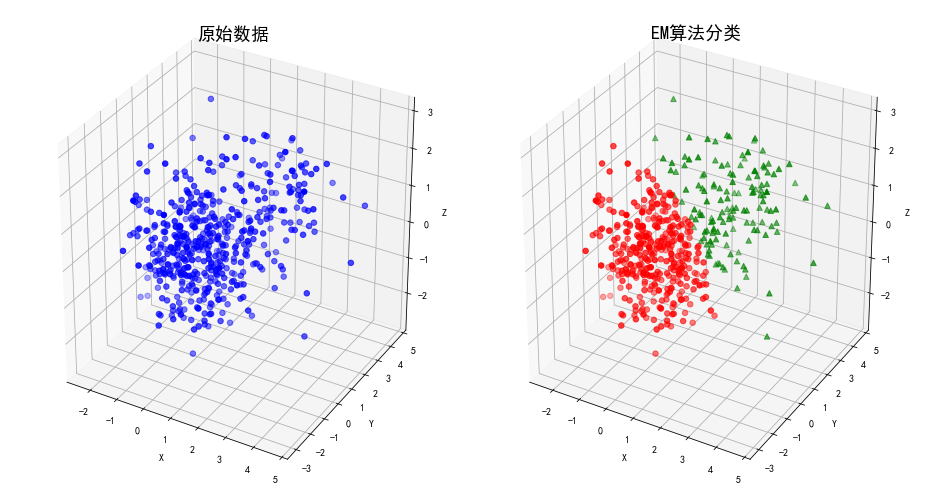

In [4]:
# 预测分类
norm1 = multivariate_normal(mu1, sigma1)
norm2 = multivariate_normal(mu2, sigma2)
tau1 = norm1.pdf(data)
tau2 = norm2.pdf(data)

fig = plt.figure(figsize=(13, 7), facecolor='w')
ax = fig.add_subplot(121, projection='3d')
ax.scatter(data[:, 0], data[:, 1], data[:, 2], c='b', s=30, marker='o', depthshade=True)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title(u'原始数据', fontsize=18)
ax = fig.add_subplot(122, projection='3d')
order = pairwise_distances_argmin([mu1_fact, mu2_fact], [mu1, mu2], metric='euclidean')
if order[0] == 0:
    c1 = tau1 > tau2
else:
    c1 = tau1 < tau2
c2 = ~c1
acc = np.mean(y == c1)
print (u'准确率：%.2f%%' % (100*acc))
ax.scatter(data[c1, 0], data[c1, 1], data[c1, 2], c='r', s=30, marker='o', depthshade=True)
ax.scatter(data[c2, 0], data[c2, 1], data[c2, 2], c='g', s=30, marker='^', depthshade=True)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title(u'EM算法分类', fontsize=18)
# plt.suptitle(u'EM算法的实现', fontsize=20)
# plt.subplots_adjust(top=0.92)
plt.tight_layout()
plt.show()

In [ ]:
# 自己实现

In [3]:
style = 'me'

np.random.seed(0)
mu1_fact = (0, 0, 0)
cov_fact = np.identity(3)
data1 = np.random.multivariate_normal(mu1_fact, cov_fact, 400) #多元正态分布矩阵
mu2_fact = (2, 2, 1)
cov_fact = np.identity(3)
data2 = np.random.multivariate_normal(mu2_fact, cov_fact, 100)
data = np.vstack((data1, data2))
y = np.array([True] * 400 + [False] * 100)

if style=='sklearn':
    g = GaussianMixture(n_components=2, covariance_type='full', tol=1e-6, max_iter=1000) #GMM混合高斯模型
    g.fit(data)
    print ('类别概率:\t', g.weights_[0])
    print ('均值:\n', g.means_, '\n')
    print ('方差:\n', g.covariances_, '\n')
    mu1, mu2 = g.means_
    sigma1, sigma2 = g.covariances_
else:
# # 自己实现
    num_iter = 100
    n, d = data.shape
    # 随机指定
    # mu1 = np.random.standard_normal(d)
    # print mu1
    # mu2 = np.random.standard_normal(d)
    # print mu2
    mu1 = data.min(axis=0)
    mu2 = data.max(axis=0)
    sigma1 = np.identity(d) #返回的是nxn的主对角线为1，其余地方为0的数组
    sigma2 = np.identity(d)
    pi = 0.5
    # EM
    for i in range(num_iter):
        # E Step
        norm1 = multivariate_normal(mu1, sigma1) #多元高斯分布
        norm2 = multivariate_normal(mu2, sigma2)
        tau1 = pi * norm1.pdf(data) # pdf(x, mean=None, cov=1) ：概率密度函数
        tau2 = (1 - pi) * norm2.pdf(data)
        gamma = tau1 / (tau1 + tau2) # 求解 gamma

        # M Step
        mu1 = np.dot(gamma, data) / np.sum(gamma) #更新 均值
        mu2 = np.dot((1 - gamma), data) / np.sum((1 - gamma)) #更新 均值
        sigma1 = np.dot(gamma * (data - mu1).T, data - mu1) / np.sum(gamma) #更新 方差
        sigma2 = np.dot((1 - gamma) * (data - mu2).T, data - mu2) / np.sum(1 - gamma) #更新 方差
        pi = np.sum(gamma) / n # 更新 pi
        print (i, ":\t", mu1, mu2)
    print ('类别概率:\t', pi)
    print ('均值:\t', mu1, mu2)
    print ('方差:\n', sigma1, '\n\n', sigma2, '\n')

0 :	 [-0.11359772 -0.11177414 -0.15582682] [1.750978   1.77295469 0.95334518]
1 :	 [-0.0939775  -0.08867467 -0.1415379 ] [1.73674934 1.74955546 0.93765719]
2 :	 [-0.08563433 -0.07998234 -0.13520388] [1.73113767 1.74304012 0.93039031]
3 :	 [-0.08160252 -0.07623707 -0.13193519] [1.72907607 1.74181727 0.9266361 ]
4 :	 [-0.07948608 -0.07449048 -0.13007819] [1.72868927 1.74249895 0.92465788]
5 :	 [-0.07827794 -0.07359204 -0.1289329 ] [1.72913547 1.74384222 0.92366889]
6 :	 [-0.0775152  -0.07305603 -0.12816899] [1.72999799 1.74536591 0.92326261]
7 :	 [-0.0769756  -0.07267274 -0.1276201 ] [1.7310608  1.74688951 0.92321165]
8 :	 [-0.07655    -0.07235237 -0.12719832] [1.73220969 1.74835366 0.92338186]
9 :	 [-0.07618418 -0.07205768 -0.12685529] [1.73338411 1.74974598 0.92369098]
10 :	 [-0.07585108 -0.07177418 -0.12656335] [1.73455232 1.75107047 0.92408711]
11 :	 [-0.07553725 -0.07149693 -0.12630607] [1.7356982  1.75233526 0.92453671]
12 :	 [-0.07523601 -0.07122473 -0.12607335] [1.73681408 1.7535

准确率：91.00%


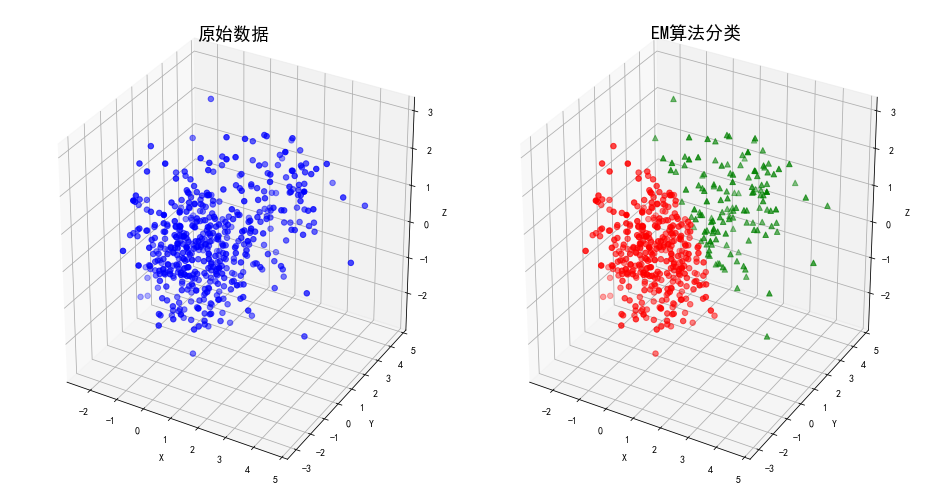

In [4]:
# 预测分类
norm1 = multivariate_normal(mu1, sigma1)
norm2 = multivariate_normal(mu2, sigma2)
tau1 = norm1.pdf(data)
tau2 = norm2.pdf(data)

fig = plt.figure(figsize=(13, 7), facecolor='w')
ax = fig.add_subplot(121, projection='3d')
ax.scatter(data[:, 0], data[:, 1], data[:, 2], c='b', s=30, marker='o', depthshade=True)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title(u'原始数据', fontsize=18)
ax = fig.add_subplot(122, projection='3d')
order = pairwise_distances_argmin([mu1_fact, mu2_fact], [mu1, mu2], metric='euclidean')
if order[0] == 0:
    c1 = tau1 > tau2
else:
    c1 = tau1 < tau2
c2 = ~c1
acc = np.mean(y == c1)
print (u'准确率：%.2f%%' % (100*acc))
ax.scatter(data[c1, 0], data[c1, 1], data[c1, 2], c='r', s=30, marker='o', depthshade=True)
ax.scatter(data[c2, 0], data[c2, 1], data[c2, 2], c='g', s=30, marker='^', depthshade=True)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title(u'EM算法分类', fontsize=18)
# plt.suptitle(u'EM算法的实现', fontsize=20)
# plt.subplots_adjust(top=0.92)
plt.tight_layout()
plt.show()